##Experiment 4: [MAIN FILE2]Transfer learning from synthetic to cityscapes FCN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
devices = tf.config.list_physical_devices('GPU')
if devices:
    for device in devices:
        print(device.name)
else:
    print('No GPU devices found')

/physical_device:GPU:0


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random
import seaborn as sns
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
train_folder="/content/drive/MyDrive/CityscapesDatasetFolder/cityscapes_data/train"
valid_folder="/content/drive/MyDrive/CityscapesDatasetFolder/cityscapes_data/val"
width = 256
height = 256
classes = 13
batch_size = 10
num_of_training_samples = len(os.listdir(train_folder)) 
num_of_testing_samples = len(os.listdir(valid_folder))

In [ ]:
print("Number of images in the training dataset:", num_of_training_samples)
print("Number of images in the testing/validation dataset:", num_of_testing_samples)


Number of images in the training dataset: 2975
Number of images in the testing/validation dataset: 500


##Preprocessing the dataset

In [ ]:
def LoadImage(name, path):
    img = Image.open(os.path.join(path, name))
    img = np.array(img)
    
    image = img[:,:256]
    mask = img[:,256:]
    
    return image, mask

In [ ]:
def bin_image(mask):
    bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])
    new_mask = np.digitize(mask, bins)
    return new_mask

In [ ]:
def getSegmentationArr(image, classes, width=width, height=height):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c ).astype(int)
    return seg_labels

In [ ]:
def give_color_to_seg_img(seg, n_classes=13):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

In [ ]:
def DataGenerator(path, batch_size=10, classes=13):
    files = os.listdir(path)
    while True:
        for i in range(0, len(files), batch_size):
            batch_files = files[i : i+batch_size]
            imgs=[]
            segs=[]
            for file in batch_files:
                #file = random.sample(files,1)[0]
                image, mask = LoadImage(file, path)
                mask_binned = bin_image(mask)
                labels = getSegmentationArr(mask_binned, classes)

                imgs.append(image)
                segs.append(labels)

            yield np.array(imgs), np.array(segs)

In [ ]:
train_gen = DataGenerator(train_folder, batch_size=batch_size)
val_gen = DataGenerator(valid_folder, batch_size=batch_size)

In [ ]:
imgs, segs = next(train_gen)
imgs.shape, segs.shape

((10, 256, 256, 3), (10, 256, 256, 13))

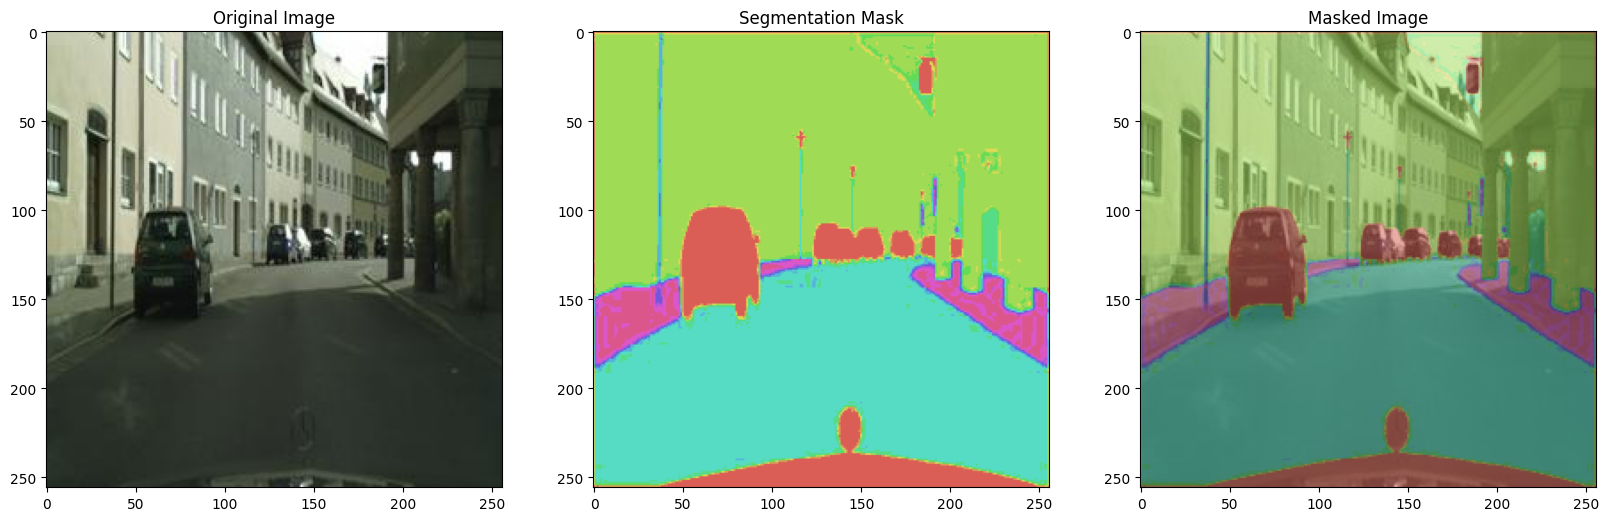

In [ ]:
image = imgs[0]
mask = give_color_to_seg_img(np.argmax(segs[0], axis=-1))
masked_image = cv2.addWeighted(image/255, 0.5, mask, 0.5, 0)

fig, axs = plot.subplots(1, 3, figsize=(20,20))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(mask)
axs[1].set_title('Segmentation Mask')
axs[2].imshow(masked_image)
axs[2].set_title('Masked Image')
plot.show()

##Model and transfer learning

In [ ]:
def fcn(classes=13, fcn8=False, fcn16=False):
    inputs = tf.keras.Input(shape=(width, height, 3))

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    if fcn8:
        up6 = Conv2DTranspose(classes, kernel_size=(16, 16), strides=(8, 8), padding='same')(conv5)
    elif fcn16:
        up6 = Conv2DTranspose(classes, kernel_size=(8, 8), strides=(4, 4), padding='same')(conv5)
    else:
        up6 = Conv2DTranspose(classes, kernel_size=(32, 32), strides=(16, 16), padding='same')(conv5)

    output = Activation('softmax')(up6)

    model = Model(inputs=inputs, outputs=output)
    return model



In [ ]:
!pip install pydot graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


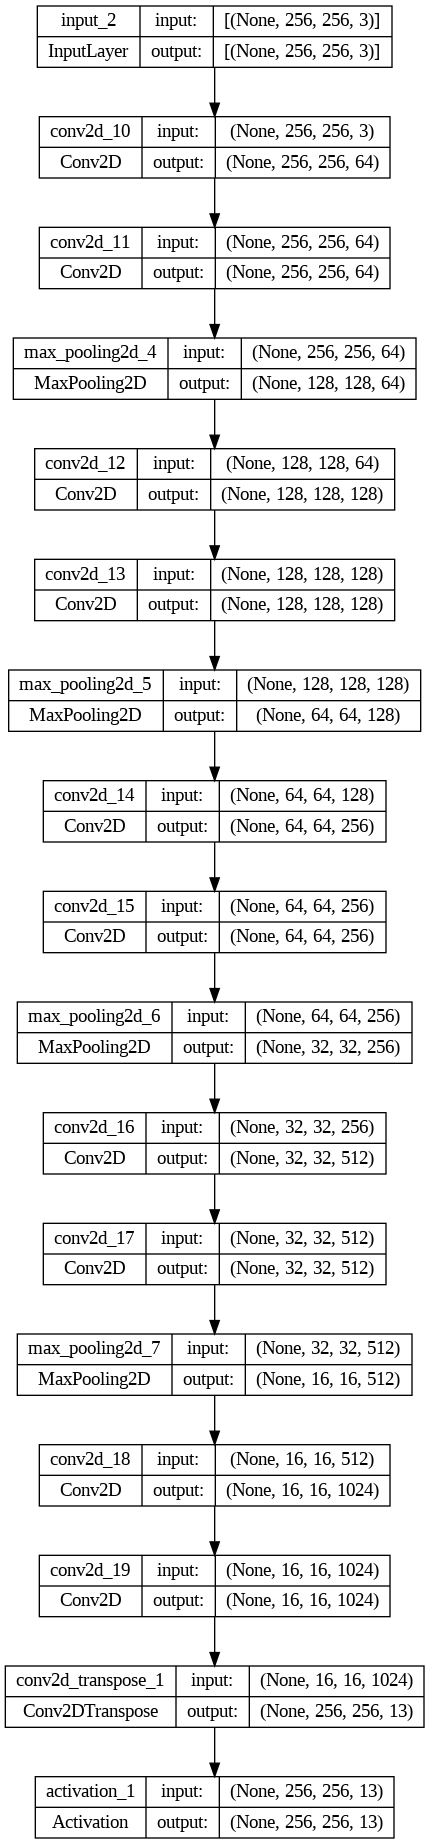

In [ ]:
from tensorflow.keras.utils import plot_model

model = fcn(classes=13, fcn8=False, fcn16=False)

# Save the model architecture diagram to a file
plot_model(model, to_file='model_architecture.png', show_shapes=True)

# Display the model architecture diagram in Jupyter Notebook
from PIL import Image
image = Image.open('model_architecture.png')
image.show()


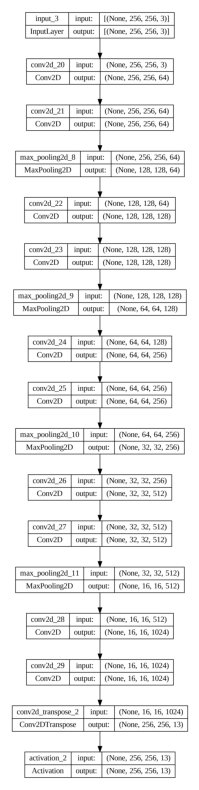

In [ ]:
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

model = fcn(classes=13, fcn8=False, fcn16=False)

# Save the model architecture diagram to a file
plot_model(model, to_file='model_architecture.png', show_shapes=True, dpi=300)

# Display the model architecture diagram in Jupyter Notebook
image = plt.imread('model_architecture.png')
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


In [ ]:
model = fcn(classes=13, fcn8=False, fcn16=False)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     147584    
                                                             

In [ ]:
from keras.models import load_model
pretrained_model = load_model('/content/drive/MyDrive/ParametersDeepLearning/notebook3/best-model-fcn.hdf5')


In [ ]:
model = fcn(classes=13)


In [ ]:
for pretrained_layer, new_model_layer in zip(pretrained_model.layers, model.layers):
    new_model_layer.set_weights(pretrained_layer.get_weights())


##Training model

In [ ]:
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
filepath = "best-model-fcn.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(train_gen, epochs=10, steps_per_epoch=num_of_training_samples // batch_size,
                    validation_data=val_gen, validation_steps=num_of_testing_samples // batch_size,
                    callbacks=callbacks_list, use_multiprocessing=True)


Epoch 1/10
297/297 [==============================] - ETA: 0s - loss: 1.0788 - accuracy: 0.6853
Epoch 1: val_accuracy improved from -inf to 0.73839, saving model to best-model-fcn.hdf5
297/297 [==============================] - 2087s 7s/step - loss: 1.0788 - accuracy: 0.6853 - val_loss: 0.9305 - val_accuracy: 0.7384
Epoch 2/10
297/297 [==============================] - ETA: 0s - loss: 0.8549 - accuracy: 0.7576
Epoch 2: val_accuracy improved from 0.73839 to 0.75312, saving model to best-model-fcn.hdf5
297/297 [==============================] - 279s 940ms/step - loss: 0.8549 - accuracy: 0.7576 - val_loss: 0.8707 - val_accuracy: 0.7531
Epoch 3/10
297/297 [==============================] - ETA: 0s - loss: 0.7948 - accuracy: 0.7744
Epoch 3: val_accuracy improved from 0.75312 to 0.76838, saving model to best-model-fcn.hdf5
297/297 [==============================] - 274s 924ms/step - loss: 0.7948 - accuracy: 0.7744 - val_loss: 0.8167 - val_accuracy: 0.7684
Epoch 4/10
297/297 [================

In [ ]:
import pickle

# Save the history object to a file
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

import pickle


In [ ]:
# Load the history object from the file
with open('history.pkl', 'rb') as file:
    history = pickle.load(file)

# Access the training and validation metrics
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

In [ ]:
# After training the model
model.save_weights("model_weights.h5")

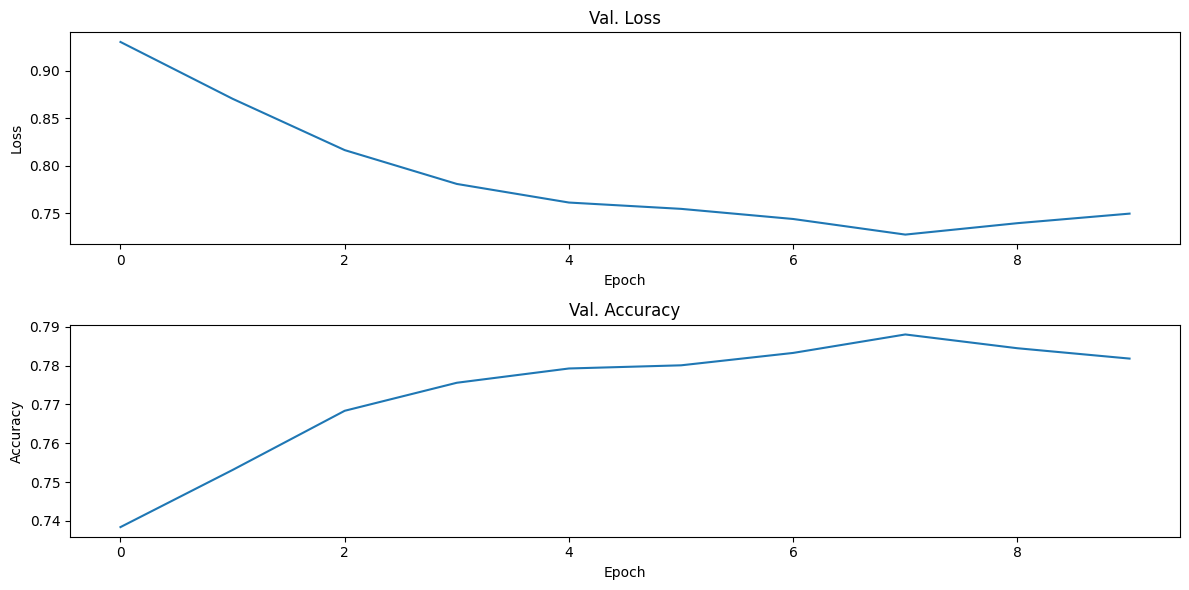

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.title("Val. Loss")
plt.plot(val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(212)
plt.title("Val. Accuracy")
plt.plot(val_accuracy)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.savefig("learn.png", dpi=150)
plt.show()


In [ ]:
model.load_weights("best-model-fcn.hdf5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


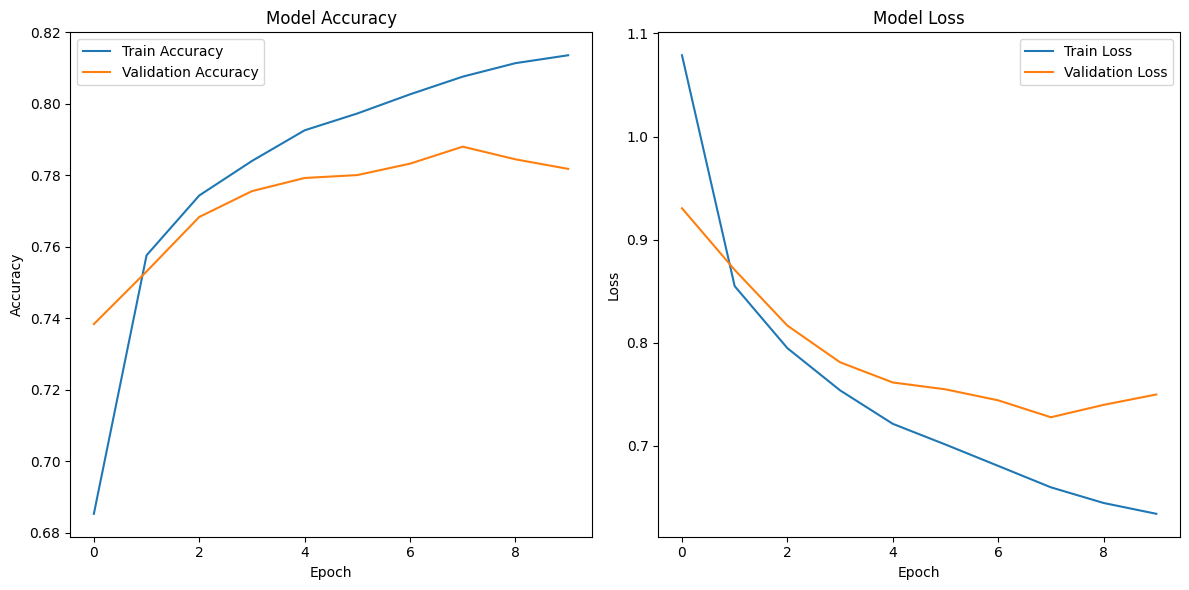

<ipython-input-35-840644201c34>:33: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_accuracy = model.evaluate_generator(val_gen, steps=num_of_testing_samples // batch_size)


Validation Loss: 0.7277679443359375
Validation Accuracy: 0.78805011510849


In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load the saved history
with open('/content/history.pkl', 'rb') as file:
    history = pickle.load(file)

# Print available metrics
print(history.keys())

# Plot accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate_generator(val_gen, steps=num_of_testing_samples // batch_size)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

1/1 [==============================] - 0s 198ms/step


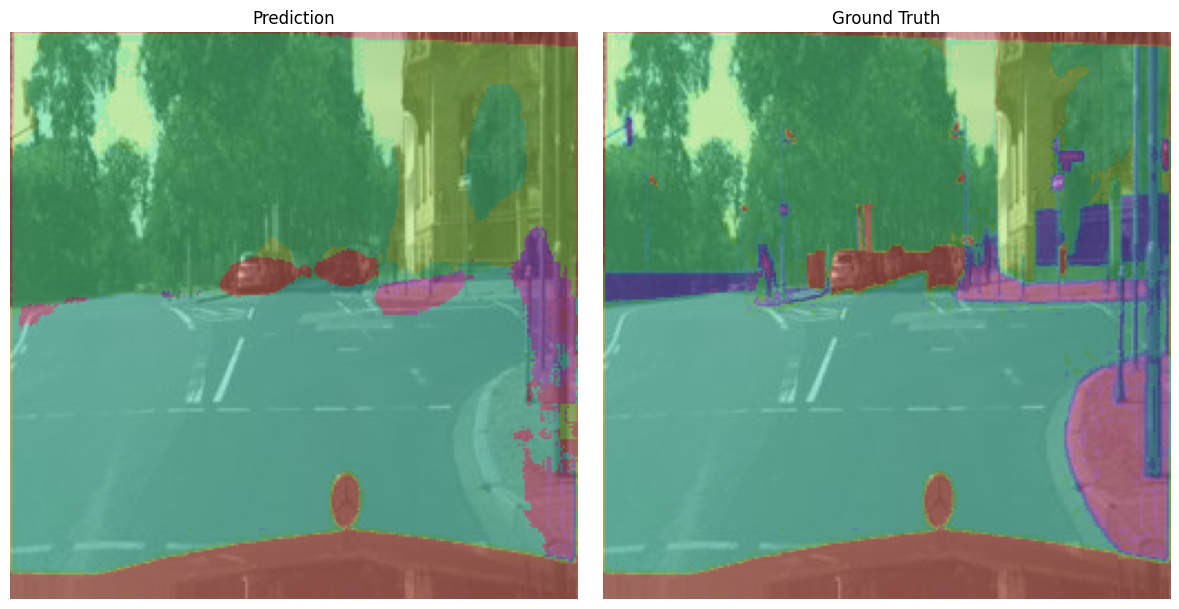

In [ ]:
max_show = 1
imgs, segs = next(val_gen)
pred = model.predict(imgs)

for i in range(max_show):
    _p = give_color_to_seg_img(np.argmax(pred[i], axis=-1))
    _s = give_color_to_seg_img(np.argmax(segs[i], axis=-1))

    predimg = cv2.addWeighted(imgs[i]/255, 0.5, _p, 0.5, 0)
    trueimg = cv2.addWeighted(imgs[i]/255, 0.5, _s, 0.5, 0)

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.title("Prediction")
    plt.imshow(predimg)
    plt.axis("off")
    
    plt.subplot(122)
    plt.title("Ground Truth")
    plt.imshow(trueimg)
    plt.axis("off")
    
    plt.tight_layout()
    plt.savefig("pred_{}.png".format(i), dpi=150)
    plt.show()


In [ ]:
import shutil

source_path = "/content/pred_0.png"
destination_path = "/content/drive/MyDrive/ParametersDeepLearning/note4/pred_0.png"

shutil.copyfile(source_path, destination_path)


'/content/drive/MyDrive/ParametersDeepLearning/note4/pred_0.png'